<a href="https://colab.research.google.com/github/vvicky30/Deep_neural_Networks_PyTorch/blob/master/BacthNorm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Batch Normalization with the MNIST Dataset</h1>

<h2>Table of Contents</h2>
In this lab, you will build a Neural Network using Batch Normalization and compare it to a Neural Network that does not use Batch Normalization. You will use the MNIST dataset to test your network. 

<ul>
<li><a href="#Train_Func">Neural Network Module and Training Function</a></li>
<li><a href="#Makeup_Data">Load Data </a></li>
<li><a href="#NN">Define Several Neural Networks, Criterion function, Optimizer</a></li>
<li><a href="#Train">Train Neural Network using Batch Normalization and no Batch Normalization</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
</div>
<hr>

<h2>Preparation</h2>

We'll need the following libraries:  

In [1]:
# These are the libraries will be used for this lab.

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

<!--Empty Space for separating topics-->

<h2 id="Train_Func">Neural Network Module and Training Function</h2> 

Define the neural network module or class 

 Neural Network Module with two hidden layers using Batch Normalization

In [2]:
# Define the Neural Network Model using Batch Normalization

class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)#hidden layer 1
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)#hidden layer2
        self.linear3 = nn.Linear(n_hidden2, out_size)#output layer
        #creating object from constructor nn.BatchNorm1d
        self.bn1 = nn.BatchNorm1d(n_hidden1)#batch normalization for hidden layer 1
        self.bn2 = nn.BatchNorm1d(n_hidden2)#batch normalization for hidden layer r
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))#supplying output of linear regression to the activation fn along with batch normalisation 
        x = self.bn2(torch.sigmoid(self.linear2(x)))#same here for hidden layer 2
        x = self.linear3(x)#remained same for multiclass softmax prediction
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))#applying batch normalization on output of linar regression of hidden layer 1
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)#applying activation on batch-normalised values for hidden layer 1
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1)) #applying batch normalization on output of linar regression of hidden layer 2
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)#applying activation on batch-normalised values for hidden layer 2
        out.append(a2.detach().numpy().reshape(-1))
        return out

Neural Network Module with two hidden layers with out Batch Normalization

In [3]:
# Class Net for Neural Network Model: here we build ordinary neural network same as above but without batch normalisation

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results :here is no batch normalized value passes to the respective activatio fn of hidden layers
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 


Define a function to train the model. In this case the function returns a Python dictionary to store the training loss and accuracy on the validation data 

In [8]:
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

<!--Empty Space for separating topics-->

<h2 id="Makeup_Data">Make Some Data</h2> 

Load the training dataset by setting the parameters <code>train </code> to <code>True</code> and convert it to a tensor  by placing a transform object int the argument <code>transform</code>

In [5]:
# load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Load the validating dataset by setting the parameters train  <code>False</code> and convert it to a tensor by placing a transform object into the argument <code>transform</code>

In [6]:
# load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

create the training-data loader and the validation-data loader object 

In [7]:
# Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a id="ref3"></a>
<h2 align=center>Define Neural Network, Criterion function, Optimizer and Train the  Model  </h2> 

Create the criterion function  

In [9]:
# Create the criterion function

criterion = nn.CrossEntropyLoss()

Variables for Neural Network Shape <code> hidden_dim</code> used for number of neurons in both hidden layers.

In [10]:
# Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

<!--Empty Space for separating topics-->

<h2 id="Train">Train Neural Network using Batch Normalization and no Batch Normalization </h2> 

Train Neural Network using  Batch Normalization :

In [11]:
# Create model, optimizer and train the model

model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)

Train Neural Network with no Batch Normalization:

In [12]:
# Create model without Batch Normalization, optimizer and train the model

model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

<h2 id="Result">Analyze Results</h2> 

Compare the histograms of the activation for the first layer of the first sample, for both models.

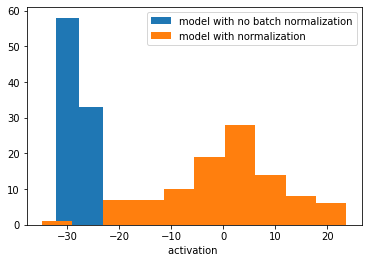

In [13]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

<!--Empty Space for separating topics-->

We see the activations with Batch Normalization are zero centred and have a smaller variance.

Compare the training loss for each iteration

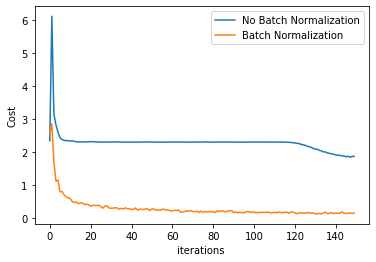

In [14]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

Compare the validating accuracy for each iteration

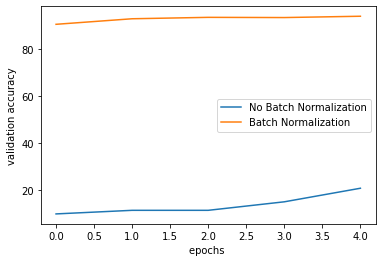

In [15]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()